In [ ]:
# -----********************-----

# Created Time: 2025/07/03

# Author: Yiyi He, Tiger Peng

### Use Case

# This notebook create uniform voltage data using the scraped minute-wise voltage data
# The two main data sources in this project are the current operating ESMI station data,
# which is scraped from the Prayas ESMI website using the india_esmi_scraper.py scraper,
# as well as the Harvard Dataverse Data


# The Harvard Dataverse Data is formatted in a 60 x n grid, with each row being labelled with an hour in the day, from 0-23,
# and each of the columns being a minute of the hour from 0-59.

# The scraped data is formatted in two columns, with the time column being the datetime down to the minute,
# and the voltage column being the voltage from 0-255.
# -----********************-----

# Libraries

In [1]:
import os
import pandas as pd
from tqdm import tqdm
import shutil
from datetime import datetime, timedelta
import numpy as np
import math

# ESMI and Harvard Dataverse ID

In addition to having different data formats, the two data sources also use different numbering systems.
Harvard Dataverse uses the names of the 528 stations covered in the time period of the dataset, between 2014-2018.
The ESMI scraper uses the ESMI ids assigned in the dropdown elements used by the web scraper to select stations on the Prayas website.

The India station locations were all cross-referenced (still need to document this), with duplicates and stations outside of the ERA5-land dataset removed. Each of the newly-scraped ESMI stations was given an ID number proceeding 528 (the last number assigned to the Dataverse stations), with duplicates in the Dataverse data removed.

After this process, we have ids from 1-572 (with some missing because duplicates were removed), and a uniform data format.

These files will all be stored in the india_processing/india_uniform directory, and their IDs can be referenced in the file ESMI_India_538_locations.csv.

## Converting Dataverse Voltage Data

We first need to verify that all of the stations deemed to be in the ERA5 dataset's range is in either the Dataverse dataset or the ESMI dataset.

In [2]:
def strip_name(name, exceptions = None):
    formatted = name.split('-')[0].split('[')[0].strip()
    
    if exceptions:
        return exceptions(formatted) # run the name through the entered exceptions function, if provided
    else:
        return formatted

In [3]:
# Import the location information table, which we can use to map between station_id, ESMI_ID, and station names.
# Target filename: ESMI_India_538_locations.csv
locations_path = "/Users/yiyi/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology(2)/Research/Energy_resilience/01_data/processed/ESMI_India_538_locations.csv"
locations = pd.read_csv(locations_path, dtype={"ESMI_ID" : str, "station_id" : int}, usecols=["station_id", "ESMI_ID", "Location name", "District", "State", "Lat", "Lon"])
locations.rename(columns={"Location name": "station_name", "District" : "district", "State": "state", "Lat": "lat", "Lon": "lon"}, inplace=True)
locations["station_name"] = locations["station_name"].apply(strip_name)

In [7]:
locations.head()

,station_id,station_name,ESMI_ID,district,state,lat,lon
0,1,5th phase JP Nagar,NaN,Bengaluru Urban,Karnataka,12.901092,77.589150
1,2,80 feet road,NaN,Dhule,Maharashtra,20.895199,74.775982
2,3,Adarsh Nagar,NaN,Saharsa,Bihar,25.883507,86.614919
3,4,Adgaon,NaN,Nashik,Maharashtra,20.037184,73.850136
4,5,Agarchitti,NaN,Chamoli,Uttarakhand,30.016116,79.308735


In [8]:
# Get the unique names from all of the Harvard Dataverse spreadsheets
dataverse_dir = "/Users/yiyi/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology(2)/Research/Energy_resilience/01_data/processed/india_dataverse"
stations_found = set()
for file in os.listdir(dataverse_dir):
    if file.endswith('.csv'):
        data = pd.read_csv(os.path.join(dataverse_dir, file))
        stations_found.update(data["Location name"].unique())

stations_found = set([strip_name(x) for x in stations_found])

/var/folders/cy/f8598vm53cggn74m01d5s0rc0000gr/T/ipykernel_33155/869827649.py:6: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join(dataverse_dir, file))


In [9]:
# Add all of the station ids to a set to be checked against the available names/ids in either dataset
station_names = set(locations["station_name"])

# Update, checking off all the names found in the dataverse name field
stations_remaining = station_names.difference(stations_found)
print(stations_remaining)
len(stations_remaining)

{'Kothrud', 'Hedayetpur', 'Guwahati Club', 'Ameerpet', 'Dudhimati', 'Nagaon', 'Vidya Nagar', 'Khatorbari', 'Chanho', 'Juri Par Shanti Path', 'Capital Electrical Subdivision', 'Kapoorthla', 'Borbheta', 'Besant Nagar', 'Datalpara', 'Ulubari', 'Kardaitola', 'Mahuadanr', 'ASEB Campus', 'Gohaibari', 'Tezpur', 'Chouparan', 'Saheed Nagar', 'Deopur', 'Bamunimaidan', 'Mihijam', 'Netarhat', 'Kolebira', 'Kairo', 'Lalmatia', 'Perka', 'Satbarwa', 'Banjara Hills', 'Rajdhani Masjid', 'GNB road', 'Nichinta', 'Zalim Khurd', 'Amrit Nagar', 'Sahakar Nagar', 'Tarun Nagar', 'Alipur', 'Haider Nagar', 'Bhurkunda', 'Bilasipara', 'Domadih'}


45

In [15]:
# Get the station_ids of the stations still unaccounted for after the dataverse data
station_ids_remaining = set(locations[(locations['station_name'].isin(stations_remaining))]['station_id'])

In [17]:
# Print all of the station names that we haven't found but expected to, ids less than 529, because those we expect to find in 
for id in station_ids_remaining:
    if int(id) < 529:
        print(locations[locations['station_id'] == id]['station_name'].values[0])

print(stations_found.difference(station_names))

GNB road
Gohaibari
ASEB Campus
Guwahati Club
Hedayetpur
Bamunimaidan
Juri Par Shanti Path
Tarun Nagar
Capital Electrical Subdivision
Ulubari
Vidya Nagar
Datalpara
{'Nepal _6417', 'VidyaNagar', 'Santacruz', 'Yadthare', 'GNB road Guwahati', 'Bamunimaidan Guwahati', 'Nepal _4496', 'Sukhbaderi (S)', 'ASEB Campus Guwahati', 'Maruti Vethika Road', 'Ameerpeth', 'MG Road Panjim', 'Ulubari Guwahati', 'Sukhbaderi (N)', 'Miramar Panjim', 'Alwarpet', 'KT_4355', 'Subhash road Ratnagiri', 'Tilak Ali Ratnagiri', 'Palamu_2', 'Tarun Nagar Guwahati', 'Karnataka_7', 'Surakalpeth Cuddalore', 'Nepal _8193', 'Brahmavar', 'Benaulim', 'Uttardah (S)', 'Kapoorthala', 'Carambolim', 'Sancole', 'Capital Electrical Subdivision Guwahati', 'KT_8961', 'Dehradun_5', 'Colva', 'Guwahati Club Guwahati', 'Devpur', 'Saheed Nagar Bhubaneswar', 'Sayapettai Chinnasandhu', 'Nepal _5791', 'Sahakarnagar', 'Masipidi', 'Gimhavne', 'Juri Par Shanti Path Guwahati', 'Siddhapura', 'Nakre', 'Gohaibari Guwahati', 'Nerul', 'Bhubaneswar_5'

In [18]:
# Function to deal with exceptions in name formatting
def name_exceptions(name):
    if name == "VidyaNagar":
        return "Vidya Nagar"
    if "Guwahati" in name: # Remove Guwahati from the end
        return " ".join(name.split(" ")[:-1])
    return name

In [22]:
stations_found = set([strip_name(x, name_exceptions) for x in stations_found])
stations_remaining = station_names.difference(stations_found)

station_ids_remaining = set(locations[(locations['station_name'].isin(stations_remaining))]['station_id'])

for id in station_ids_remaining:
    if int(id) < 529:
        print(locations[locations['station_id'] == id]['station_name'])

149    Guwahati Club
Name: station_name, dtype: object


In [23]:
esmi_dir = "/Users/yiyi/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology(2)/Research/Energy_resilience/01_data/processed/esmi_scraped/india_esmi"

esmi_found = set() # set for the esmi_ids found
for file in os.listdir(esmi_dir):
    if file.endswith('.csv'):
        esmi_found.add(file.split('+')[0])

ids_found = set(locations[locations['ESMI_ID'].isin(esmi_found)]['station_id'])

In [24]:
final_remaining = station_ids_remaining.difference(ids_found)
print(final_remaining)

{161}


## Convert to uniform format

First, we can simply rename the ESMI stations according to their uniform station id.

In [ ]:
uniform_dir = "/Users/yiyi/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology(2)/Research/Energy_resilience/01_data/processed/india_uniform"
esmi_dir = "/Users/yiyi/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology(2)/Research/Energy_resilience/01_data/processed/esmi_scraped/india_esmi"

# Copy the scraped EMSI data files from "india_esmi" to "india_uniform" and rename the file to "station_[uniform_id]"
for file in os.listdir(esmi_dir):
    if file.endswith('.csv'):
        esmi_id = file.split('+')[0]
        uniform_id = locations[locations['ESMI_ID'] == esmi_id]['station_id'].values[0]

        shutil.copy(os.path.join(esmi_dir, file), os.path.join(uniform_dir, f'station_{uniform_id}.csv'))

In [69]:
# [Optional] The code below checks what the "uniform_id" is for a given "ESMI ID"
locations[locations.ESMI_ID == 212]

,station_id,station_name,ESMI_ID,district,state,lat,lon
498,533,Srirampura,212,Bengaluru,Karnataka,13.068737,77.614819


Then, we convert the Dataverse format into our uniform format.
This involves taking each of the individual rows, taking the date and hour columns, along with the index of the minutes columns and transforming that into a vertical 2xn of datetime, voltage values, which can be concatenated together.

Then we will use our existing name parsing to section each of the sheets by station.
After this has been done for every station, we can save it to our uniform data location, taking care not to override any existing sheets, as the stations which are duplicate between ESMI and Dataverse, ESMI takes priority.

Also, as we discovered later in the Cleanup section, the 2019Jan_Jun.csv has data quality problems which have to be address before we can incorporate it into our uniform dataset.

In [ ]:
dataverse_dir = "/Users/yiyi/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology(2)/Research/Energy_resilience/01_data/processed/india_dataverse"

# Filter out just the locations that aren't actively scraped ESMI locations
# so we avoid mapping them to a location number when processing dataverse data.
rem_locations = locations[pd.isna(locations['ESMI_ID'])]
name_to_station_id = dict(zip(rem_locations['station_name'].to_list(), rem_locations['station_id'].to_list())) # Create dictionary to make id lookup more efficient

In [ ]:
for file in os.listdir(dataverse_dir):
    if "2019" in file: # Skip 2019 for now
        continue
    print(file)
    hd_df = pd.read_csv(os.path.join(dataverse_dir, file), header=0)

    # Remove the weird excel export #VALUE! artifacts
    hd_df.replace('#VALUE!', pd.NA, inplace=True)
    hd_df.dropna(inplace=True)
    hd_df.iloc[:, -60:] = hd_df.iloc[:, -60:].apply(pd.to_numeric)

    # Merge the date and hour columns to create a pd datetime
    if '/' in hd_df['Date'][0]:
        hd_df.insert(loc=1, column='time', value=(pd.to_datetime(hd_df['Date'], format='%m/%d/%Y') + pd.to_timedelta(hd_df['Hour'], unit='h')))
    elif '-' in hd_df['Date'][0]:
        hd_df.insert(loc=1, column='time', value=(pd.to_datetime(hd_df['Date'], format='%d-%m-%Y') + pd.to_timedelta(hd_df['Hour'], unit='h')))
    else:
        print('Invalid date format')
        break
        
    hd_df.drop(['Date', 'Hour'], axis=1, inplace=True)
    
    # Derive the uniform station_id from the station names
    hd_df.rename(columns={'Location name': 'station_name'}, inplace=True)
    
    # Create a new column of uniform station_ids, assigning -1 if it is a station we have already discarded, so we can ignore it
    hd_df.insert(loc=0, column='station_id', value=hd_df['station_name'].apply(lambda x : name_to_station_id.get(strip_name(x, exceptions=name_exceptions), -1)))
    hd_df.drop('station_name', axis=1, inplace=True)
    
    unpivoted_rows = []
    for index in tqdm(range(hd_df.shape[0])):
        if hd_df.iloc[index, 0] == -1: # Skip irrelevant or already covered stations
            continue
            
        unpivoted_row = hd_df.iloc[[index], :].melt(id_vars=['station_id', 'time'], ignore_index=True)
        unpivoted_row['time'] = unpivoted_row['time'] + pd.to_timedelta(unpivoted_row['variable'].apply(lambda x : int(x.split(' ')[1])), unit='m')
        
        unpivoted_rows.append(unpivoted_row)
    
    unpivoted_df = pd.concat(unpivoted_rows)
    unpivoted_df.drop('variable', axis=1, inplace=True)
    unpivoted_df.rename(columns={'value': 'voltage'}, inplace=True)

    # If the station_data already exists, append the new data on the end, otherwise, write directly to a new csv
    for station_id in unpivoted_df['station_id'].unique():
        output_path = os.path.join(uniform_dir, f'station_{station_id}.csv')
        subset_df = unpivoted_df[unpivoted_df['station_id'] == station_id]
        subset_df = subset_df.drop('station_id', axis=1)
        
        if os.path.exists(output_path):
            station_df = pd.read_csv(output_path, header=0, parse_dates=['time'])
            if station_df['time'].iloc[-1] < subset_df['time'].iloc[0]:
                station_df = pd.concat((station_df, subset_df))
                station_df.to_csv(output_path, index=False) # Saving to uniform dir
        else:
            subset_df.to_csv(output_path, index=False) # Saving to uniform dir
    

## Dealing with 2019Jan-Jun
Because there are the presence of duplicate rows, both duplicate in the timestamp and station. I will just remove these duplicate rows.

There is also the issue of erroneous voltage values, such as voltages of 535 or 999, which do not appear elsewhere in the dataverse dataset. I choose to simply ignore rows which contain values greater than 400 entirely, because in the way that we aggregate voltage data over hours or days, removal of a single datapoints is equivalent to removal of the entire hour anyways.

We also take special care to simply remove the data of Bodireddypally-Prakasam and Kanheri Sarap, as the repeat rate is very high, and what can be salvaged may be questionable.

In [ ]:
for file in os.listdir(dataverse_dir):
    if not "2019" in file: # Only operate on the 2019 dataset
        continue
    print(file)
    hd_df = pd.read_csv(os.path.join(dataverse_dir, file), header=0)

    # Remove the weird excel export #VALUE! artifacts
    hd_df.replace('#VALUE!', pd.NA, inplace=True)
    hd_df.dropna(inplace=True)
    hd_df.iloc[:, -60:] = hd_df.iloc[:, -60:].apply(pd.to_numeric)
    hd_df.iloc[:, -60:][hd_df.iloc[:, -60:] > 400] = pd.NA
    hd_df.dropna(inplace=True) # Ignore rows with values greater than 400 

    # Merge the date and hour columns to create a pd datetime
    if '/' in hd_df['Date'][0]:
        hd_df.insert(loc=1, column='time', value=(pd.to_datetime(hd_df['Date'], format='%m/%d/%Y') + pd.to_timedelta(hd_df['Hour'], unit='h')))
    elif '-' in hd_df['Date'][0]:
        hd_df.insert(loc=1, column='time', value=(pd.to_datetime(hd_df['Date'], format='%d-%m-%Y') + pd.to_timedelta(hd_df['Hour'], unit='h')))
    else:
        print('Invalid date format')
        break
        
    hd_df.drop(['Date', 'Hour'], axis=1, inplace=True)
    
    # Derive the uniform station_id from the station names
    hd_df.rename(columns={'Location name': 'station_name'}, inplace=True)
    
    # Create a new column of uniform station_ids, assigning -1 if it is a station we have already discarded, so we can ignore it
    hd_df.insert(loc=0, column='station_id', value=hd_df['station_name'].apply(lambda x : name_to_station_id.get(strip_name(x, exceptions=name_exceptions), -1)))
    hd_df.drop('station_name', axis=1, inplace=True)

    hd_df = hd_df[hd_df['station_id'] != -1]
    hd_df = hd_df[hd_df['station_id'] != 223]
    hd_df = hd_df[hd_df['station_id'] != 86] # Remove all the high error rate and irrelevant stations

    station_ids = hd_df['station_id'].unique()
    
    stations_2019 = {}
    for station_id in station_ids:
        print(station_id)
        unpivoted_rows = []
        station_df = hd_df[hd_df['station_id'] == station_id]

        station_df = station_df[~station_df.duplicated(subset=['time'], keep=False)] # Remove duplicate times

        for index in tqdm(range(station_df.shape[0])):
            unpivoted_row = station_df.iloc[[index], :].melt(id_vars=['station_id', 'time'], ignore_index=True)
            unpivoted_row['time'] = unpivoted_row['time'] + pd.to_timedelta(unpivoted_row['variable'].apply(lambda x : int(x.split(' ')[1])), unit='m')
            unpivoted_rows.append(unpivoted_row)

        unpivoted_df = pd.concat(unpivoted_rows)
        unpivoted_df.drop('variable', axis=1, inplace=True)
        unpivoted_df.rename(columns={'value': 'voltage'}, inplace=True)

        stations_2019[station_id] = unpivoted_df

## Inspecting the Quality of the Post-2019 Data

We have reason to believe that the data quality post-2019 would be lower than that of before, because the program which pertained to the harvard dataverse sites ended in 2019. Just for a first order check before we incorporate the 2019 data, I will see if the mean and std of the voltage is substantially different before and after 2019.

In [ ]:
station_ids = []
mean_diffs = []
mean1s = []
mean2s = []
std_diffs = []
std1s = []
std2s = []

for station_id in stations_2019.keys():
    output_path = os.path.join(uniform_dir, f'station_{station_id}.csv')
    station_df_new = stations_2019[station_id]
    
    if os.path.exists(output_path):
        station_df = pd.read_csv(output_path, header=0, parse_dates=['time'])
        station_ids.append(station_id)
        mean1 = station_df['voltage'].mean()
        mean1s.append(mean1)
        mean2 = station_df_new['voltage'].mean()
        mean2s.append(mean2)

        mean_diffs.append(np.abs(mean1 - mean2))

        std1 = station_df['voltage'].std()
        std1s.append(std1)
        std2 = station_df_new['voltage'].std()
        std2s.append(std2)

        std_diffs.append(np.abs(std1 - std2))

In [ ]:
mean_diffs_arr = np.array(mean_diffs)
means1_arr = np.array(mean1s)
means2_arr = np.array(mean2s)
std_diffs_arr = np.array(std_diffs)
std1s_arr = np.array(std1s)
std2s_arr = np.array(std2s)

mean_diffs_normalized = mean_diffs_arr / std1s_arr
sorted_diffs = np.argsort(mean_diffs_normalized)

print("Mean Differences")
print(mean_diffs_arr[sorted_diffs[-10:]])
print(mean_diffs_normalized[sorted_diffs[-10:]])

Mean Differences

[ 66.86783524 100.22082143  98.36311681  37.29250032  49.31260174
  79.76807313  74.52002874 175.2608046  239.52322478 242.16721693]

[0.95419399 1.0269152  1.0873201  1.17463552 1.40466063 1.51603714
 1.68559889 4.38305177 7.22517917 9.97748979]

 Seeing as how some of the mean diffs are more than one full standard deviation, I think that Changmin's theory about the poor data quality of the 2019 dataset is valid, and for the time being, I will just save them to their own separate dataset.

In [ ]:
# If the station_data already exists, append the new data on the end, otherwise, write directly to a new csv
post_2019_dir = "../india_processing/india_uniform_2019"

for station_id, station_df in stations_2019.items():
    output_path = os.path.join(post_2019_dir, f'station_{station_id}.csv') 
    station_df.to_csv(output_path, index=False)

# ***Aggregating Voltage Data into Usable Metrics

Before we can perform any analysis on correlation between weather factors and power outages in India, we first aggregate the power data into something that can be used.

The data being processed here is the station data that comes directly from the india_esmi_scraper or from the modified Harvard Dataverse station data.
ESMI data comes minute-wise, and ERA5 weather data comes hour-wise, so it is necessary to minimally convert the ESMI data to hourly data.
Additionally, the ESMI data is not complete, meaning we have to apply our discretion when choosing the times and stations with which to perform our analysis.
To give ourselves the maximum flexibility, we will process the data into 7 versions:

- **Outage Events**: timestamped with outage beginning and duration
- **Hourly Data**: each complete hour with the percentage of the time period being spent at voltage = 0
- **Daily Aggregate Outage Events**: each complete day with the frequency of power outage events and average duration of said events, aggregated from the first outage events dataset
- **Interpolated Minute-wise Data**: because the data is incomplete, but in some cases may only be minorly incomplete, we can set some arbitrary threshold of missing minutes that we are willing to interpolate, and save that interpolated minutewise data
- **Interpolated Hourly Data**: the same procedure to acquire the hourly data except apply to the interpolated data
- **Interpolated Outages**: the same procedure used to acquire the outages, except applied to the interpolated data
- **Interpolated Daily Aggregate Outage Events**: the same procedure used to acquire the daily aggregate outage frequency and duration, except applied to the interpolated data

In [ ]:
### [Optional]
### Interpolation Experiments
# First, let's determine what our interpolation method should be by looking at the shape of the voltage curves
sample_path = os.path.join(uniform_dir, 'station_12.csv')
sample_df = pd.read_csv(sample_path, header=0, index_col=None, parse_dates=['time'])
sample_df.head()

,time,voltage
0,2014-11-24 09:00:00,241.0
1,2014-11-24 09:01:00,241.0
2,2014-11-24 09:02:00,241.0
3,2014-11-24 09:03:00,242.0
4,2014-11-24 09:04:00,242.0


<Axes: xlabel='time', ylabel='voltage'>

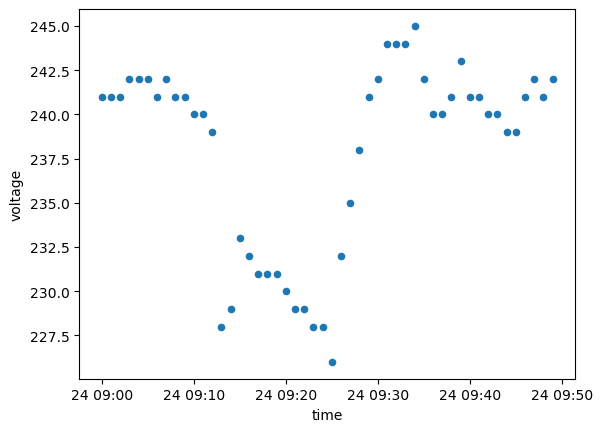

In [ ]:
### [Optional]
sample_df[0:50].plot(kind='scatter', x='time', y='voltage')

We can see that while the overall trend is linear, at the two or three minute level, the data tends to take an almost stepwise format, staying at a value for one or two minutes before advancing to the next one.

So, for my first pass, I'll be looking to perform some form of nearest-value fill, just filling either end of a missing range with either it's beginning or end value.

Please note that I would only apply this form of interpolation to short quantities of missing information, one to three minutes, not large sequences.

In [ ]:
### [Optional]
# Interpolation
def interpolate(begin_range, end_range, begin_value, end_value, mode='nearfill'):
    # begin_range and end_range are both included in the original series
    # the output will be a dataframe including both begin_range and end_range, as well as the filled values in between
    times = [begin_range]
    voltages = [begin_value]
    difference = round((end_range - begin_range).seconds / 60)
    if mode == 'nearfill':
        for i in range(1, difference):
            curr_time = begin_range + timedelta(minutes=i)
            times.append(curr_time)
            if i <= int(difference / 2):
                voltages.append(begin_value)
            else:
                voltages.append(end_value)
        times.append(end_range)
        voltages.append(end_value)

    output_df = pd.DataFrame({'time': times, 'voltage': voltages})
    return output_df

Now we can begin looping through all of the uniform data points, saving all of these relevant datasets.

In [ ]:
### [Optional]
# TAKES A LONG TIME TO RUN
station_files = os.listdir(uniform_dir)
num_stations = len(station_files)
for index, file in enumerate(station_files):
    print(f'Station {index + 1}/{num_stations}: {file}')

    station_df = pd.read_csv(os.path.join(uniform_dir, file), header=0, index_col=False, parse_dates=['time'])
    time_difference = station_df['time'].diff()
    print(time_difference.apply(lambda x : x.total_seconds()).value_counts())

From the results we find that the shorter gaps in time largely don't exist, so we will be ditching interpolation, as we don't have an effective way to accurately fill the typical gaps of an hour or more.

Next we can make the aggregate hourly and daily statistics.

The aggregate statistic for hourly is the percentage duration of outage in the hour, and for daily, we will both do gross duration, as well as a measurement of outage frequency (discrete events) and average outage duration.

In [ ]:
hourly_dir = "/Users/yiyi/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology(2)/Research/Energy_resilience/01_data/processed/india_hourly"

In [ ]:
# Loop through, getting to the next whole hour.
# If the position 60 minutes from it is not the next whole hour, we know that data is incomplete.
station_files = os.listdir(uniform_dir)
num_stations = len(station_files)
for index, file in enumerate(station_files):
    print(f'Station {index + 1}/{num_stations}: {file}')
    station_df = pd.read_csv(os.path.join(uniform_dir, file), header=0, index_col=False, parse_dates=['time'])

    hours = []
    pct_blackout = []
    index = 0
    previous_hour = None
    while index + 60 < station_df.shape[0]:
        if previous_hour is None:
            if station_df['time'][index].minute == 0 and station_df['time'][index].second == 0:
                previous_hour = station_df['time'][index]
        else:
            # If the hour is complete, we take the percentage of that portion of the dataset that is 0 voltage, and save that with the datetime of the
            # beginning of the one hour period
            next_hour = previous_hour + timedelta(hours = 1, minutes = 0, seconds = 0)
            if station_df['time'][index + 60] == next_hour:
                hours.append(previous_hour)
                pct = station_df['voltage'][index:index+60].value_counts().get(0, 0) / 60
                pct_blackout.append(pct)
                index = index + 60
                previous_hour = next_hour
            else:
                # We can backtrack until we hit the next whole hour or before, then do the sixty minutes test again
                while station_df['time'][index] >= next_hour:
                    print(f'{station_df["time"][index]}, {next_hour}')
                    if station_df['time'][index] == next_hour:
                        previous_hour = next_hour
                        break
                    else:
                        index -= 1 
                if station_df['time'][index] < next_hour:
                    while index < station_df.shape[0]:
                        curr_time = station_df['time'][index]
                        if curr_time.minute == 0 and curr_time.second == 0 and curr_time > previous_hour:
                            previous_hour = curr_time
                            break
                        else:
                            index += 1

    id = file.split('_')[1].split('.')[0]
    hourly_df = pd.DataFrame({'hour': hours, 'pct_blackout': pct_blackout})
    hourly_df.to_csv(os.path.join(hourly_dir, f'hourly_station_{id}.csv'), index=False)

Next we can acquire the complete days and loop through to get the outages, which will be split along day boundaries to make the calculation of the aggregate measures simpler, as well as the gross duration.

In [ ]:
daily_dir = "/Users/yiyi/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology(2)/Research/Energy_resilience/01_data/processed/india_daily"
outages_dir = "/Users/yiyi/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology(2)/Research/Energy_resilience/01_data/processed/india_outages"
agg_outages_dir = "/Users/yiyi/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology(2)/Research/Energy_resilience/01_data/processed/india_daily_aggregate_outages"

In [ ]:
# Loop through, getting to the next whole hour. If the position 60 minutes from it is not the next whole hour, we know that data is incomplete.
station_files = os.listdir(uniform_dir)
num_stations = len(station_files)
for index, file in enumerate(station_files):
    print(f'Station {index + 1}/{num_stations}: {file}')
    station_df = pd.read_csv(os.path.join(uniform_dir, file), header=0, index_col=False, parse_dates=['time'])

    # Lists later converted into daily gross outage duration dataframe
    days = []
    pct_blackout = []

    # Lists later converted into per station outages dataframe
    outage_starts = []
    outage_ends = []
    outage_durations = []

    # Lists later converted into per station daily aggregate outage dataframe
    agg_outage_days = []
    avg_outage_durations = []
    outage_frequencies = []
    index = 0
    previous_day = None
    while index + 1439 < station_df.shape[0]:
        if previous_day is None:
            if station_df['time'][index].hour == 0 and station_df['time'][index].minute == 0 and station_df['time'][index].second == 0:
                previous_day = station_df['time'][index]
            else:
                index += 1
        else:
            # If the day is complete, we take the percentage of that portion of the dataset that is 0 voltage, and save that with the datetime of the
            # beginning of the one hour period
            end_of_hour = previous_day + timedelta(hours = 23, minutes = 59)
            next_day = end_of_hour + timedelta(minutes = 1)
            if station_df['time'][index + 1439] == end_of_hour:
                days.append(previous_day)
                pct = station_df['voltage'][index:index+1440].value_counts().get(0, 0) / 1440
                pct_blackout.append(pct)

                # In addition to getting the gross duration, we also loop through to get the outages for the station for this complete day
                outage_starts_today = []
                outage_ends_today = []
                outage_durations_today = []
                outage_start = None
                outage_continuing = False
                for i in range(index, index + 1440):
                    if station_df['voltage'][i] == 0:
                        if not outage_continuing: # outage start
                            outage_start = station_df['time'][i]
                            outage_continuing = True
                    else:
                        if outage_continuing: # outage end
                            outage_end = station_df['time'][i]
                            duration = outage_end - outage_start
                            duration = duration.total_seconds() / 60

                            outage_starts_today.append(outage_start)
                            outage_ends_today.append(outage_end)
                            outage_durations_today.append(duration)

                            outage_continuing = False
                            outage_start = None

                # Append to overall station outages lists
                outage_starts.extend(outage_starts_today)
                outage_ends.extend(outage_ends_today)
                outage_durations.extend(outage_durations_today)
                
                # Compute daily aggregate outage statistics
                if len(outage_durations_today):
                    avg_duration = np.mean(outage_durations_today)
                else:
                    avg_duration = 0
                freq = len(outage_starts_today)

                agg_outage_days.append(previous_day)
                avg_outage_durations.append(avg_duration)
                outage_frequencies.append(freq)
                
                index = index + 1440
                previous_day = None # allow the script to reacquire the next day
            else:
                # We can backtrack until we hit the next whole hour or before, then do the 1439 minutes test again
                while station_df['time'][index] >= next_day:
                    if station_df['time'][index] == next_day:
                        previous_day = next_day
                        break
                    else:
                        index -= 1 
                if station_df['time'][index] < next_day:
                    while index < station_df.shape[0]:
                        curr_time = station_df['time'][index]
                        if curr_time.hour == 0 and curr_time.minute == 0 and curr_time.second == 0 and curr_time > previous_day:
                            previous_day = curr_time
                            break
                        else:
                            index += 1

    id = file.split('_')[1].split('.')[0]
    # Daily csv
    daily_df = pd.DataFrame({'date': days, 'pct_blackout': pct_blackout})
    daily_df.to_csv(os.path.join(daily_dir, f'daily_station_duration_{id}.csv'), index=False)
    
    # Outages csv
    outages_df = pd.DataFrame({'outage_start': outage_starts, 'outage_end': outage_ends, 'duration': outage_durations})
    outages_df.to_csv(os.path.join(outages_dir, f'outages_station_{id}.csv'), index=False)

    # Daily aggregate outages csv
    agg_outages_df = pd.DataFrame({'date': agg_outage_days, 'avg_duration': avg_outage_durations, 'freq': outage_frequencies})
    agg_outages_df.to_csv(os.path.join(agg_outages_dir, f'agg_outages_station_{id}.csv'), index=False)

## Converting Hourly Weather Data into Daily Aggregate Data

The two main operations that we have to do for the extraction of the hourly data is to take the difference between the current and previous total precpitations, as tp is an accumulation variable, meaning it is strictly increasing throughout the day and represents the total precipitation up to that point in the day.

For the daily aggregate data, we simply take the average over a day of most of the weather variables, and for the tp accumulation variable, we take the value that is present at 12:00 AM the next day, which is confusingly the total accumulated precipitation for the previous day.

In addition, we calculate a cluster of other weather variables, such as relative humidity.